In [12]:
# set env via .env file
#import os
import sys
import pathlib 
import numpy as np
import pandas as pd
#import tensorflow as tf
from importlib import reload
#import pandas_datareader.data as web
#import requests_cache
import datetime
import munch

import math
#from cachetools import TTLCache
#import time
#import ray
#import psutil
#from sqlalchemy import create_engine
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
#import qgrid
# import mpl_finance as mf

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import shared
import config
import provider_yfinance as provider
import plot

reload(shared)
reload(config)
reload(provider)
reload(plot)

plot.Notebook()

mpl.rcParams['figure.figsize'] = (16, 9)
mpl.rcParams['axes.grid'] = False
mpl.rcParams['axes.unicode_minus']=False
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)


In [13]:
cfg = config.get_config('^GDAXI', True)
config.overwrite_end_dt(cfg, '2020-01-07')
config.save_config(cfg)

config> current directory:/mnt/c/notebooks/sandbox
config> data period: from '2018-02-13' to '2020-01-14'
config> download period: from '2017-11-28' to '2020-01-14'
shared> parsing stocks from web '^GDAXI' ...
config> benchmarks: '['000001.SS', 'AUDUSD=X', 'BTCUSD=X', 'CNY=X', 'ETHUSD=X', 'EURCAD=X', 'EURCHF=X', 'EURGBP=X', 'EURHUF=X', 'EURJPY=X', 'EURJPY=X', 'EURSEK=X', 'EURUSD=X', 'GBPJPY=X', 'GBPUSD=X', 'GC=F', 'HKD=X', 'IDR=X', 'IMOEX.ME', 'INR=X', 'JPY=X', 'KW=F', 'LC=F', 'LH=F', 'MXN=X', 'MYR=X', 'NZDUSD=X', 'PA=F', 'PHP=X', 'PL=F', 'RUB=X', 'S=F', 'SGD=X', 'SI=F', 'SM=F', 'THB=X', 'ZAR=X', '^AORD', '^AXJO', '^BFX', '^BSESN', '^BUK100P', '^BVSP', '^DJI', '^FCHI', '^FTSE', '^GDAXI', '^GSPC', '^GSPTSE', '^HSI', '^IPSA', '^IXIC', '^JKSE', '^JN0U.JO', '^KLSE', '^KS11', '^MERV', '^MXX', '^N100', '^N225', '^NYA', '^NZ50', '^RUT', '^STI', '^STOXX50E', '^TA125.TA', '^TWII', '^VIX', '^XAX']'
config> stocks: '['1COV.DE', 'ADS.DE', 'ALV.DE', 'BAS.DE', 'BAYN.DE', 'BEI.DE', 'BMW.DE', 'CON.DE'

In [3]:
%%time
# total: 17 s

cfg_stocks, data_stocks = provider.load_stocks(cfg)

CPU times: user 78.1 ms, sys: 62.5 ms, total: 141 ms
Wall time: 169 ms


In [4]:
%%time

# total: 25 s

cfg_benchmarks, data_benchmarks = provider.load_benchmarks(cfg)

CPU times: user 438 ms, sys: 125 ms, total: 562 ms
Wall time: 745 ms


In [5]:
dates = next(shared.filter_dates_generator(cfg, -1))
dates

Munch({'train_start_dt': datetime.datetime(2019, 8, 20, 0, 0), 'train_end_dt': datetime.datetime(2019, 8, 23, 0, 0), 'predict_start_dt': datetime.datetime(2019, 8, 24, 0, 0), 'predict_end_dt': datetime.datetime(2019, 8, 24, 0, 0)})

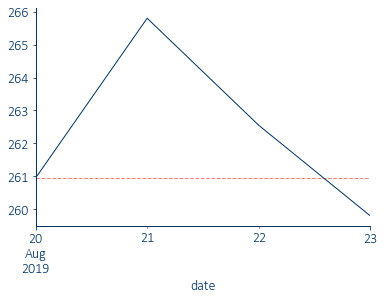

In [6]:
s = provider.get_ticker_feature(data_stocks, 'ADS.DE', 'close', dates)
s.plot()
plt.hlines(s[0], xmin=s.index[0], xmax=s.index[-1], colors='red', linestyles='dashed', alpha=.5)

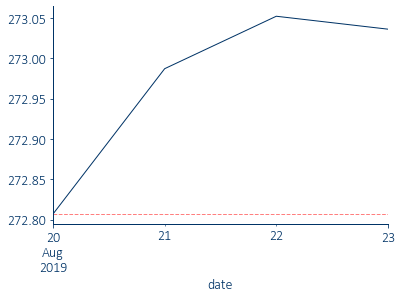

In [7]:
s = provider.get_ticker_feature(data_stocks, 'ADS.DE', 'close', dates, provider.tf_ma(cfg.train.window_trading_days[-1]))
s.plot()
plt.hlines(s[0], xmin=s.index[0], xmax=s.index[-1], colors='red', linestyles='dashed', alpha=.5)

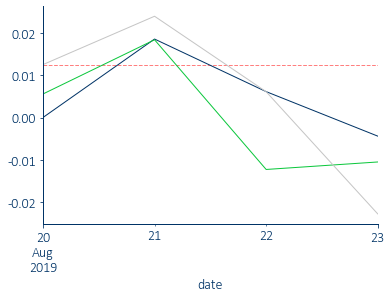

In [8]:
s = provider.get_ticker_feature(data_stocks, 'ADS.DE', 'close', dates, provider.tf_rel) - 1
s.plot()
s = provider.get_ticker_feature(data_stocks, 'ADS.DE', 'close', dates, provider.tf_loglag(cfg.train.lag_trading_days[0]))
s.plot()
s = provider.get_ticker_feature(data_stocks, 'ADS.DE', 'close', dates, provider.tf_loglag(cfg.train.lag_trading_days[1]))
s.plot()
plt.hlines(s[0], xmin=s.index[0], xmax=s.index[-1], colors='red', linestyles='dashed', alpha=.5)

In [9]:
features = set()
for k in cfg_stocks.data.keys():
    features |= set(cfg_stocks.data[k].keys())
for k in cfg_benchmarks.data.keys():
    features |= set(cfg_benchmarks.data[k].keys())
features = sorted(list(features))
features

['balancesheet',
 'calendar',
 'calls',
 'cashflow',
 'earnings',
 'financials',
 'history',
 'info',
 'puts',
 'recommendations',
 'sustainability']

In [10]:
stats_stocks = pd.DataFrame.from_dict(cfg_stocks.data, orient='index', columns=features)
stats_stocks['type'] = 'stock'
stats_benchmarks = pd.DataFrame.from_dict(cfg_benchmarks.data, orient='index', columns=features)
stats_benchmarks['type'] = 'benchmark'
df_stats = pd.concat([stats_stocks, stats_benchmarks])
df_stats.to_csv(f'{cfg.prepare.cache_dir}/metrics.csv')

In [11]:
df_stats

,balancesheet,calendar,calls,cashflow,earnings,financials,history,info,puts,recommendations,sustainability,type
1COV.DE,"(4, 28)","(1, 6)",NaN,"(4, 20)","(4, 2)","(4, 22)","(1079, 7)",117,NaN,NaN,"(1, 28)",stock
ADS.DE,"(4, 27)","(1, 6)",NaN,"(4, 19)","(4, 2)","(4, 22)","(5506, 7)",118,NaN,"(2, 4)","(1, 28)",stock
ALV.DE,"(4, 27)","(1, 6)",NaN,"(4, 2)","(4, 2)","(4, 22)","(5867, 7)",117,NaN,NaN,"(1, 28)",stock
BAS.DE,"(4, 27)","(1, 6)",NaN,"(4, 20)","(0, 6)","(4, 22)","(5875, 7)",117,NaN,NaN,"(1, 28)",stock
BAYN.DE,"(4, 28)","(1, 6)",NaN,"(4, 18)","(4, 2)","(4, 22)","(5877, 7)",116,NaN,NaN,"(1, 28)",stock
...,...,...,...,...,...,...,...,...,...,...,...,...
^STOXX50E,"(6, 0)",NaN,NaN,"(6, 0)","(0, 6)","(6, 0)","(8440, 7)",61,NaN,NaN,NaN,benchmark
^TA125.TA,"(6, 0)",NaN,NaN,"(6, 0)","(0, 6)","(6, 0)","(5546, 7)",61,NaN,NaN,NaN,benchmark
^TWII,"(6, 0)",NaN,NaN,"(6, 0)","(0, 6)","(6, 0)","(5537, 7)",61,NaN,NaN,NaN,benchmark
^VIX,"(6, 0)",NaN,"(25, 13)","(6, 0)","(0, 6)","(6, 0)","(7564, 7)",61,"(18, 13)",NaN,NaN,benchmark
